# PyTorch Tabular

For part 5, we will use the supervised models from PyTorch Tabular.

In [ ]:
!pip install pytorch_tabular

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
import torch
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
X = pd.read_csv('X.csv')
Y = pd.read_csv('Y.csv')

In [3]:
data = X.join(Y)
num_col_names = data.columns.tolist()
cat_col_names = []

In [4]:
del num_col_names[-1]

In [5]:
num_col_names

['Age',
 'Weight',
 'Height',
 'Neck',
 'Chest',
 'Abdomen',
 'Hip',
 'Thigh',
 'Knee',
 'Ankle',
 'Biceps',
 'Forearm',
 'Wrist',
 'BMI',
 'BMI/Abdomen',
 'Abdomen/Weight',
 'Chest/Abdomen',
 'Wrist/Forearm',
 'Ankle/Knee',
 'Hip/Ankle']

In [6]:
data.head()

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,...,Forearm,Wrist,BMI,BMI/Abdomen,Abdomen/Weight,Chest/Abdomen,Wrist/Forearm,Ankle/Knee,Hip/Ankle,BodyFat
0,23.0,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,...,27.4,17.1,0.033605,0.000394,1.810446,1.092723,0.624088,0.587131,4.315068,12.3
1,22.0,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,...,28.9,18.2,0.033189,0.000400,2.087349,1.127711,0.629758,0.627346,4.217949,6.1
2,22.0,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,...,25.2,16.6,0.035087,0.000399,1.751991,1.089875,0.658730,0.616967,4.133333,25.3
3,26.0,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,...,29.4,18.2,0.035392,0.000410,2.138310,1.178241,0.619048,0.611260,4.438596,10.4
4,24.0,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,...,27.7,17.7,0.036294,0.000363,1.842500,0.973000,0.638989,0.568720,4.245833,28.7


In [7]:
train, test = train_test_split(data, test_size=0.2, random_state=0)
train, val = train_test_split(train, test_size=0.1, random_state=0)



---



# Category Embedding Model

[Link](https://pytorch-tabular.readthedocs.io/en/latest/models/#category-embedding-model)

In [ ]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models.common.heads import LinearHeadConfig
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
)

data_config = DataConfig(
    target=[
        "BodyFat"
    ],  # target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
)
trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=64,
    min_epochs=20,
    max_epochs=100,
    accelerator="auto", # can be 'cpu','gpu', 'tpu', or 'ipu' 
)
optimizer_config = OptimizerConfig()


head_config = LinearHeadConfig(
    #layers='32', # No additional layer in head, just a mapping layer to output_dim
    #activation="Softplus",
    dropout=0.0,
    initialization="kaiming",
    use_batch_norm=False
).__dict__ # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

model_config = CategoryEmbeddingModelConfig(
    task="regression",
    use_batch_norm =False,
    layers="32-16-1", # Number of nodes in each layer
    activation="LeakyReLU", # Activation between each layers
    dropout=0.0,
    initialization="kaiming",
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
    learning_rate = 1e-3
)


tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

tabular_model.fit(train=train, validation=val)
result = tabular_model.evaluate(test)
pred_df = tabular_model.predict(test)

2023-05-04 23:54:47,360 - {pytorch_tabular.tabular_model:102} - INFO - Experiment Tracking is turned off
INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_lite.utilities.seed:Global seed set to 42
2023-05-04 23:54:47,391 - {pytorch_tabular.tabular_model:465} - INFO - Preparing the DataLoaders
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
2023-05-04 23:54:47,396 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for regression task
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for regression task
2023-05-04 23:54:47,417 - {pytorch_tabular.tabular_model:508} - INFO - Preparing the Model: CategoryEmbeddingModel
INFO:pytorch_tabular.tabular_model:Preparing the Model: CategoryEmbeddingModel
2023-05-04 23:54:47,450 - {pytorch_tabular.tabular_model:264} - INFO - Preparing the Trainer
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: F

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.2754228703338169
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_5a1b230c-480f-4f6d-9a3f-acab0954f5ad.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_5a1b230c-480f-4f6d-9a3f-acab0954f5ad.ckpt
2023-05-04 23:54:48,750 - {pytorch_tabular.tabular_model:560} - INFO - Suggested LR: 0.2754228703338169. For plot and detailed analysis, use `find_learning_rate` method.
INFO:pytorch_tabular.tabular_model:Suggested LR: 0.2754228703338169. For plot and detailed analysis, use `find_learning_rate` method.
2023-05-04 23:54:48,757 - {pytorch_tabular.tabular_model:566} - INFO - Training Started
INFO:pytorch_tabular.tabular_model:Training Started


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  1.2 K │
│ 1 │ _embedding_layer │ Embedding1dLayer          │     40 │
│ 2 │ head             │ LinearHead                │      2 │
│ 3 │ loss             │ MSELoss                   │      0 │
└───┴──────────────────┴───────────────────────────┴────────┘

Trainable params: 1.3 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.3 K                                                                                                
Total estimated model params size (MB): 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=20` or `min_steps=None` has not been met. Training will continue...


2023-05-04 23:54:53,113 - {pytorch_tabular.tabular_model:568} - INFO - Training the model completed
INFO:pytorch_tabular.tabular_model:Training the model completed
2023-05-04 23:54:53,117 - {pytorch_tabular.tabular_model:1207} - INFO - Loading the best model
INFO:pytorch_tabular.tabular_model:Loading the best model


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     17.65951919555664     │
│  test_mean_squared_error  │     17.65951919555664     │
└───────────────────────────┴───────────────────────────┘

Output()

In [ ]:
pred_df.head()

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,...,Wrist,BMI,BMI/Abdomen,Abdomen/Weight,Chest/Abdomen,Wrist/Forearm,Ankle/Knee,Hip/Ankle,BodyFat,BodyFat_prediction
158,30.0,136.50,68.75,35.9,88.7,76.6,89.8,50.1,34.8,21.8,...,16.9,0.028879,0.000377,1.781984,1.157963,0.496329,0.626437,4.119266,12.5,6.937536
83,70.0,170.75,70.00,38.7,101.8,94.9,95.0,56.0,36.5,24.1,...,19.2,0.034847,0.000367,1.799262,1.072708,0.703297,0.660274,3.941909,27.0,19.689533
170,35.0,152.25,67.75,37.0,92.2,81.9,92.8,54.7,36.2,22.1,...,17.7,0.033169,0.000405,1.858974,1.125763,0.645985,0.610497,4.199095,3.0,10.559484
101,48.0,173.75,72.00,37.0,99.1,92.0,98.3,59.3,38.4,22.4,...,17.0,0.033517,0.000364,1.888587,1.077174,0.648855,0.583333,4.388393,20.4,19.139286
150,26.0,152.25,69.00,35.4,92.9,77.6,93.5,56.9,35.9,20.4,...,17.8,0.031979,0.000412,1.961985,1.197165,0.613793,0.568245,4.583333,9.4,6.316311


In [ ]:
Y_train = train['BodyFat'].values
Y_test = test['BodyFat'].values

Y_train_pred = tabular_model.predict(train)["BodyFat_prediction"].values
Y_test_pred = tabular_model.predict(test)["BodyFat_prediction"].values

Output()

Output()

# Training results:

Text(0.5, 1.0, 'MSE=19.45295553350512, MAE=3.61160043557485, R2=0.7206185398985376')

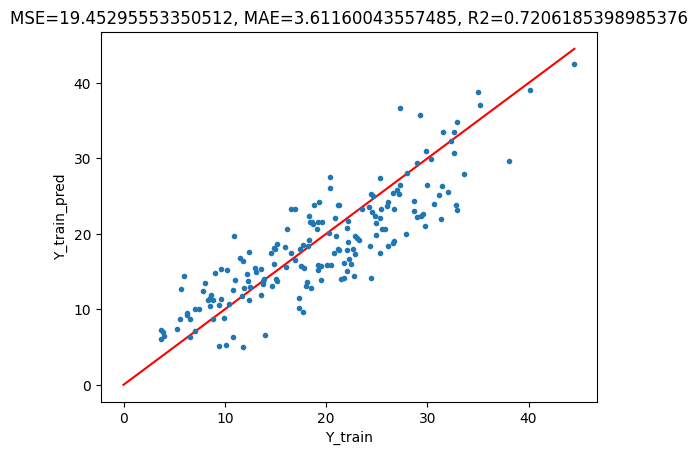

In [ ]:
from sklearn.metrics import r2_score

MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
R2 = r2_score(Y_train, Y_train_pred)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))

# Testing results:

Text(0.5, 1.0, 'MSE=17.659519279213036, MAE=3.3475187507330197, R2=0.7558242164525064')

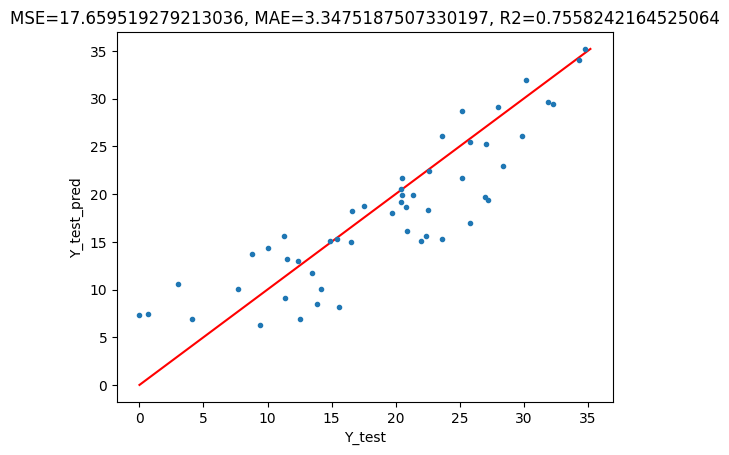

In [ ]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
R2 = r2_score(Y_test, Y_test_pred)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))



---



# Gated Additive Tree Ensemble (GATE)

[Link](https://pytorch-tabular.readthedocs.io/en/latest/models/#gated-additive-tree-ensemble-gate)

In [17]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models.common.heads import LinearHeadConfig
from pytorch_tabular.models import GatedAdditiveTreeEnsembleConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
)

data_config = DataConfig(
    target=[
        "BodyFat"
    ],  # target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
)
trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=64,
    min_epochs=100,
    max_epochs=200,
    accelerator="auto", # can be 'cpu','gpu', 'tpu', or 'ipu' 
)
optimizer_config = OptimizerConfig()


head_config = LinearHeadConfig(
    #layers='32', # No additional layer in head, just a mapping layer to output_dim
    #activation="Softplus",
    dropout=0.0,
    initialization="kaiming",
    use_batch_norm=False
).__dict__ # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

model_config = GatedAdditiveTreeEnsembleConfig(
    task="regression",
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
    learning_rate = 1e-3
)


tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

tabular_model.fit(train=train, validation=val)
result = tabular_model.evaluate(test)
pred_df = tabular_model.predict(test)

2023-05-05 19:23:38,807 - {pytorch_tabular.tabular_model:102} - INFO - Experiment Tracking is turned off
INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_lite.utilities.seed:Global seed set to 42
2023-05-05 19:23:38,845 - {pytorch_tabular.tabular_model:465} - INFO - Preparing the DataLoaders
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
2023-05-05 19:23:38,857 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for regression task
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for regression task
2023-05-05 19:23:38,899 - {pytorch_tabular.tabular_model:508} - INFO - Preparing the Model: GatedAdditiveTreeEnsembleModel
INFO:pytorch_tabular.tabular_model:Preparing the Model: GatedAdditiveTreeEnsembleModel
/usr/local/lib/python3.10/dist-packages/pytorch_tabular/models/base_model.py:126: UserWarning: Wandb is not installed. Please install wandb to log logits. You can install wandb using pip instal

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.19054607179632482
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_4553d0c8-c32b-4b06-8e5f-07e9c325277f.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_4553d0c8-c32b-4b06-8e5f-07e9c325277f.ckpt
2023-05-05 19:28:24,874 - {pytorch_tabular.tabular_model:560} - INFO - Suggested LR: 0.19054607179632482. For plot and detailed analysis, use `find_learning_rate` method.
INFO:pytorch_tabular.tabular_model:Suggested LR: 0.19054607179632482. For plot and detailed analysis, use `find_learning_rate` method.
2023-05-05 19:28:24,879 - {pytorch_tabular.models.gate.gate_model:221} - INFO - Data Aware Initialization of T0
INFO:pytorch_tabular.models.gate.gate_model:Data Aware Initialization of T0
2023-05-05 19:28:24,899 - {pytorch_t

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ GatedAdditiveTreesBackbone │  1.1 M │
│ 1 │ _embedding_layer │ Embedding1dLayer           │     40 │
│ 2 │ _head            │ CustomHead                 │     54 │
│ 3 │ loss             │ MSELoss                    │      0 │
└───┴──────────────────┴────────────────────────────┴────────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


2023-05-05 19:45:17,462 - {pytorch_tabular.tabular_model:568} - INFO - Training the model completed
INFO:pytorch_tabular.tabular_model:Training the model completed
2023-05-05 19:45:17,471 - {pytorch_tabular.tabular_model:1207} - INFO - Loading the best model
INFO:pytorch_tabular.tabular_model:Loading the best model


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    25.315202713012695     │
│  test_mean_squared_error  │    25.315202713012695     │
└───────────────────────────┴───────────────────────────┘

Output()

In [21]:
Y_train = train['BodyFat'].values
Y_test = test['BodyFat'].values

Y_train_pred = tabular_model.predict(train)["BodyFat_prediction"].values
Y_test_pred = tabular_model.predict(test)["BodyFat_prediction"].values

Output()

Output()

# Training results:

Text(0.5, 1.0, 'MSE=24.362700052541477, MAE=3.991959897147285, R2=0.6501052654456674')

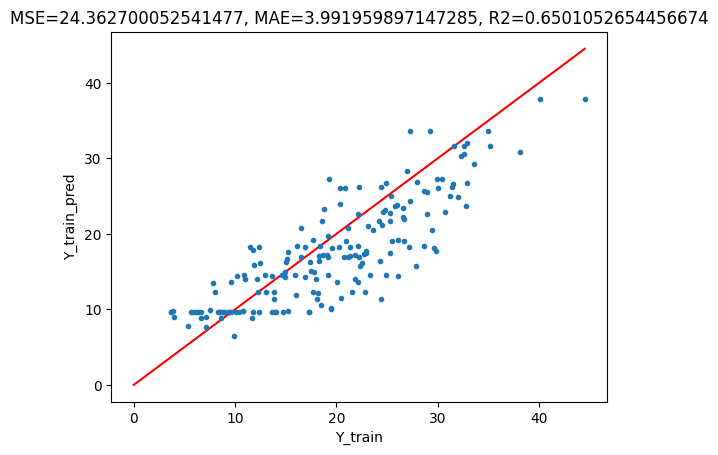

In [22]:
from sklearn.metrics import r2_score

MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
R2 = r2_score(Y_train, Y_train_pred)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))

# Testing results:

Text(0.5, 1.0, 'MSE=25.315202180551083, MAE=4.075024017633176, R2=0.6499701248733687')

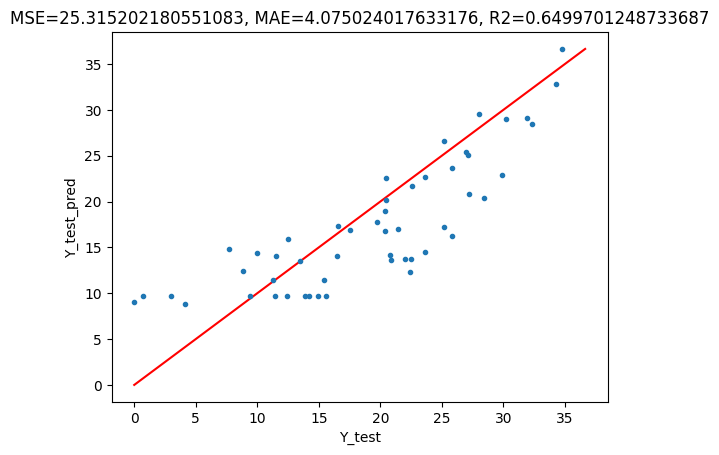

In [23]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
R2 = r2_score(Y_test, Y_test_pred)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))



---

# Neural Oblivious Decision Ensembles (NODE)

In [12]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models.common.heads import LinearHeadConfig
from pytorch_tabular.models import NodeConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
)

data_config = DataConfig(
    target=[
        "BodyFat"
    ],  # target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
)
trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=64,
    min_epochs=200,
    max_epochs=1000,
    accelerator="auto", # can be 'cpu','gpu', 'tpu', or 'ipu' 
)
optimizer_config = OptimizerConfig()


head_config = LinearHeadConfig(
    layers='32', # No additional layer in head, just a mapping layer to output_dim
    activation="Softplus",
    dropout=0.0,
    initialization="kaiming",
    use_batch_norm=False
).__dict__ # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

model_config = NodeConfig(
    task="regression",
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
    learning_rate = 1e-3,
    num_layers = 3,
    num_trees = 64,
    depth = 3,
    batch_norm_continuous_input = True

)


tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

tabular_model.fit(train=train, validation=val)

/usr/local/lib/python3.10/dist-packages/pytorch_tabular/models/node/config.py:218: UserWarning: embed_categorical is set to False and will use LeaveOneOutEncoder to encode categorical features. This is deprecated and will be removed in future versions and categorical columns will be embedded by default.
  warnings.warn(
2023-05-05 19:18:54,013 - {pytorch_tabular.tabular_model:102} - INFO - Experiment Tracking is turned off
INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_lite.utilities.seed:Global seed set to 42
2023-05-05 19:18:54,059 - {pytorch_tabular.tabular_model:465} - INFO - Preparing the DataLoaders
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
2023-05-05 19:18:54,064 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for regression task
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for regression task
2023-05-05 19:18:54,094 - {pytorch_tabular.tabular_model:508} - INFO - Preparing 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.8317637711026709
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_43e70b70-76a5-45d4-9a2a-6b13615dbf75.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_43e70b70-76a5-45d4-9a2a-6b13615dbf75.ckpt
2023-05-05 19:19:01,531 - {pytorch_tabular.tabular_model:560} - INFO - Suggested LR: 0.8317637711026709. For plot and detailed analysis, use `find_learning_rate` method.
INFO:pytorch_tabular.tabular_model:Suggested LR: 0.8317637711026709. For plot and detailed analysis, use `find_learning_rate` method.
2023-05-05 19:19:01,537 - {pytorch_tabular.models.node.node_model:82} - INFO - Data Aware Initialization of NODE using a forward pass with 2000 batch size....
INFO:pytorch_tabular.models.node.node_model:Data Aware Initializatio

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ NODEBackbone      │  166 K │
│ 1 │ _embedding_layer │ PreEncoded1dLayer │     40 │
│ 2 │ _head            │ Lambda            │      0 │
│ 3 │ loss             │ MSELoss           │      0 │
└───┴──────────────────┴───────────────────┴────────┘

Trainable params: 166 K                                                                                            
Non-trainable params: 147                                                                                          
Total params: 166 K                                                                                                
Total estimated model params size (MB): 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=200` or `min_steps=None` has not been met. Training will continue...


2023-05-05 19:20:54,135 - {pytorch_tabular.tabular_model:568} - INFO - Training the model completed
INFO:pytorch_tabular.tabular_model:Training the model completed
2023-05-05 19:20:54,139 - {pytorch_tabular.tabular_model:1207} - INFO - Loading the best model
INFO:pytorch_tabular.tabular_model:Loading the best model


In [14]:
Y_train = train['BodyFat'].values
Y_test = test['BodyFat'].values

Y_train_pred = tabular_model.predict(train)["BodyFat_prediction"].values
Y_test_pred = tabular_model.predict(test)["BodyFat_prediction"].values

Output()

Output()

# Training results:

Text(0.5, 1.0, 'MSE=22.185414918380715, MAE=3.925020287831624, R2=0.6813752233084373')

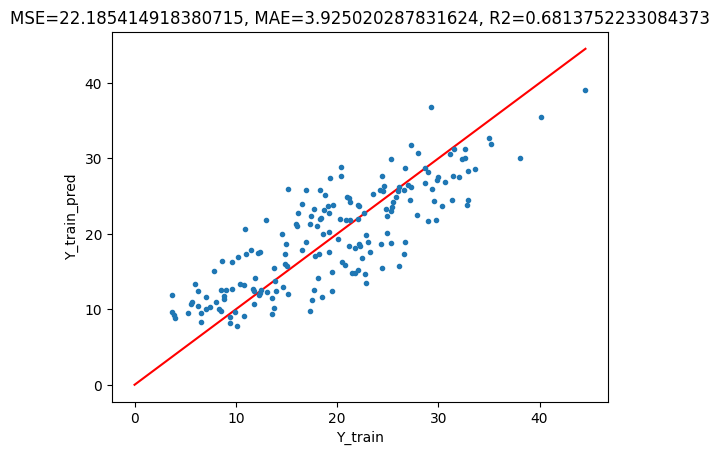

In [15]:
from sklearn.metrics import r2_score

MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
R2 = r2_score(Y_train, Y_train_pred)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))

# Testing results:

Text(0.5, 1.0, 'MSE=23.713637807360833, MAE=3.902954247418572, R2=0.6721147387522866')

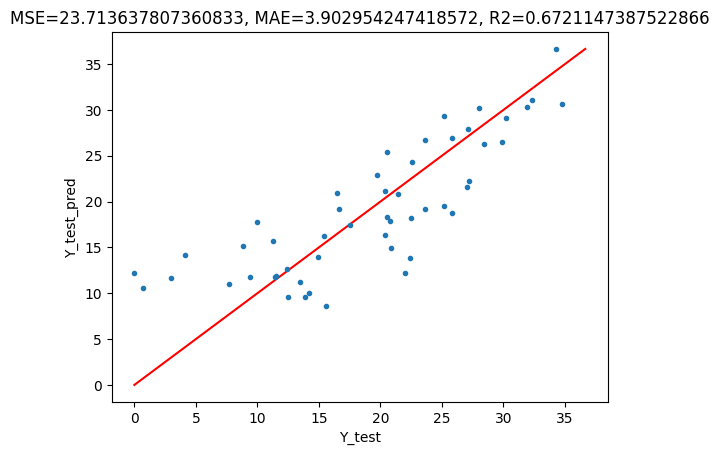

In [16]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
R2 = r2_score(Y_test, Y_test_pred)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))



---

# TabNet

[Link](https://pytorch-tabular.readthedocs.io/en/latest/models/#tabnet)

In [39]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models.common.heads import LinearHeadConfig
from pytorch_tabular.models import TabNetModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
)

data_config = DataConfig(
    target=[
        "BodyFat"
    ],  # target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
)
trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=64,
    min_epochs=40,
    max_epochs=100,
    accelerator="auto", # can be 'cpu','gpu', 'tpu', or 'ipu' 
)
optimizer_config = OptimizerConfig()


head_config = LinearHeadConfig(
    layers='32', # No additional layer in head, just a mapping layer to output_dim
    activation="Softplus",
    dropout=0.0,
    initialization="kaiming",
    use_batch_norm=False
).__dict__ # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

model_config = TabNetModelConfig(
    task="regression",
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
    learning_rate = 1e-3,
    n_steps = 6,
    virtual_batch_size = 32,
    batch_norm_continuous_input = True
)


tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

tabular_model.fit(train=train, validation=val)

2023-05-05 19:09:08,050 - {pytorch_tabular.tabular_model:102} - INFO - Experiment Tracking is turned off
INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_lite.utilities.seed:Global seed set to 42
2023-05-05 19:09:08,141 - {pytorch_tabular.tabular_model:465} - INFO - Preparing the DataLoaders
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
2023-05-05 19:09:08,153 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for regression task
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for regression task
2023-05-05 19:09:08,212 - {pytorch_tabular.tabular_model:508} - INFO - Preparing the Model: TabNetModel
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabNetModel
/usr/local/lib/python3.10/dist-packages/pytorch_tabular/models/base_model.py:126: UserWarning: Wandb is not installed. Please install wandb to log logits. You can install wandb using pip install wandb or install PyTorch Tabular usi

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.07585775750291836
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_fa29f07a-6432-434c-b762-ecaa7f790dd0.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_fa29f07a-6432-434c-b762-ecaa7f790dd0.ckpt
2023-05-05 19:09:13,831 - {pytorch_tabular.tabular_model:560} - INFO - Suggested LR: 0.07585775750291836. For plot and detailed analysis, use `find_learning_rate` method.
INFO:pytorch_tabular.tabular_model:Suggested LR: 0.07585775750291836. For plot and detailed analysis, use `find_learning_rate` method.
2023-05-05 19:09:13,838 - {pytorch_tabular.tabular_model:566} - INFO - Training Started
INFO:pytorch_tabular.tabular_model:Training Started


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type           ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _embedding_layer │ Identity       │      0 │
│ 1 │ _backbone        │ TabNetBackbone │ 11.4 K │
│ 2 │ _head            │ Identity       │      0 │
│ 3 │ loss             │ MSELoss        │      0 │
└───┴──────────────────┴────────────────┴────────┘

Trainable params: 11.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer was signaled to stop but the required `min_epochs=40` or `min_steps=None` has not been met. Training will continue...


2023-05-05 19:09:33,646 - {pytorch_tabular.tabular_model:568} - INFO - Training the model completed
INFO:pytorch_tabular.tabular_model:Training the model completed
2023-05-05 19:09:33,650 - {pytorch_tabular.tabular_model:1207} - INFO - Loading the best model
INFO:pytorch_tabular.tabular_model:Loading the best model


In [40]:
Y_train = train['BodyFat'].values
Y_test = test['BodyFat'].values

Y_train_pred = tabular_model.predict(train)["BodyFat_prediction"].values
Y_test_pred = tabular_model.predict(test)["BodyFat_prediction"].values

Output()

Output()

# Training results:

Text(0.5, 1.0, 'MSE=21.113031243913408, MAE=3.720929775767856, R2=0.6967766936015051')

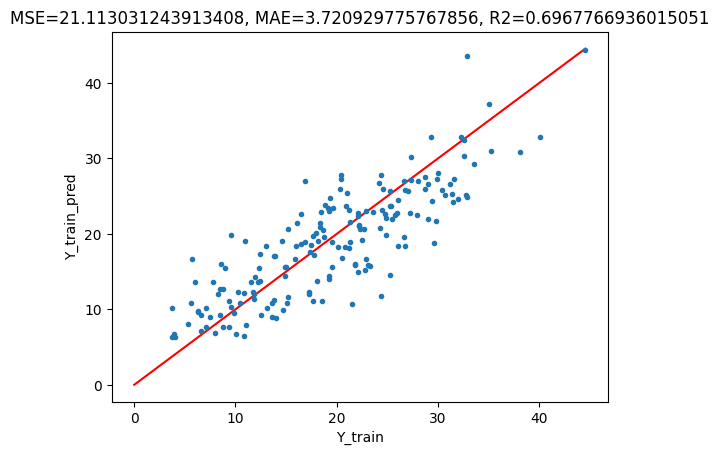

In [41]:
from sklearn.metrics import r2_score

MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
R2 = r2_score(Y_train, Y_train_pred)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))

# Testing results:

Text(0.5, 1.0, 'MSE=22.569685433994817, MAE=3.8492315965540262, R2=0.6879320134295456')

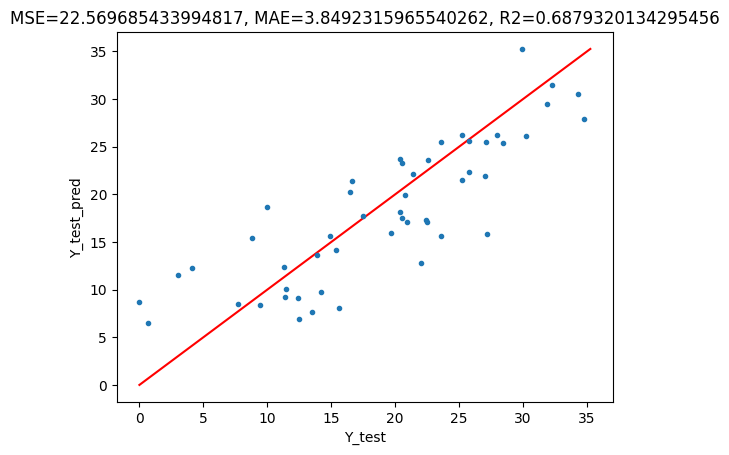

In [42]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
R2 = r2_score(Y_test, Y_test_pred)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))

# Conclusion Part 5:

These exciting models have the potential to produce good performance results. It would be interesting to fine-tune the parameters and see how far we can push them on the data set. But unfortunately, running them can be very time-consuming, so doing a grid search would take forever. But it is interesting to note that the Category Embedding Model with the default parameters already reached a performance close to the best models we tried.